# Testing solution stability

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'regular_EQL_magdir_stability.ipynb'

#### Importing auxiliary functions

In [4]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [5]:
import auxiliary_functions as fc

#### Loading properties of the model

In [6]:
with open('data/model_sphere.pickle') as f:
        model_sphere = pickle.load(f)

#### Loading properties grid

In [7]:
with open('data/regular_grid.pickle') as f:
        reg_grid = pickle.load(f)

### Saving files

In [8]:
saved_files = []

## Observation area

In [9]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (reg_grid['area'][1], 
                                                                                                reg_grid['area'][0],
                                                                                                reg_grid['area'][3],
                                                                                                reg_grid['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


### reg_grid survey information

In [10]:
print 'Shape : (%.0f,%.0f)'% reg_grid['shape'] 
print 'Number of data: %.1f' % reg_grid['N']
print 'dx: %.1f m' % reg_grid['dx']
print 'dy: %.1f m ' % reg_grid['dy']

Shape : (20,20)
Number of data: 400.0
dx: 631.6 m
dy: 631.6 m 


## Properties of the model

### Main field

In [11]:
inc_gf,dec_gf = model_sphere['main_field']

In [12]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [13]:
print 'Intensity: %.1f A/m' % model_sphere['m_R']
print 'Inclination: %.1f degree' % model_sphere['inc_R']
print 'Declination: %.1f degree' % model_sphere['dec_R']

Intensity: 3.0 A/m
Inclination: 30.0 degree
Declination: 20.0 degree


In [14]:
inc_R,dec_R = model_sphere['inc_R'],model_sphere['dec_R']

### Generating data

In [15]:
data = sphere.tf(reg_grid['x'],reg_grid['y'],reg_grid['z'],
                 model_sphere['model_R'],inc_gf,dec_gf)

In [16]:
seed = 10

In [17]:
np.random.seed(seed=seed)

In [18]:
std_noise = 7.
r = np.random.normal(0.0,std_noise, reg_grid['Nx']*reg_grid['Ny'])
data_obs =  data + r

## Generating the layer with my function 

In [19]:
h = 1800.

#### Generating a layer

In [20]:
shape_layer = (reg_grid['shape'][0],reg_grid['shape'][1])

In [21]:
xs,ys,zs = regular(reg_grid['area'],shape_layer,h)

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [22]:
i_pos = 1800

In [23]:
it_max = 30

In [24]:
it_marq = 15

In [25]:
lamb = 10.
dlamb = 100.

In [26]:
eps_e = 1e-4
eps_i = 1e-4

In [27]:
mu_LM = 1e5

In [28]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data_obs,reg_grid['x'],reg_grid['y'],reg_grid['z'],xs,ys,zs,inc_gf,dec_gf,
    -10.,-10.,lamb,dlamb,i_pos,it_max,it_marq,eps_e,eps_i,mu_LM)

i = 0
1.68662235877 -3.00444256636
0.563810189181
i = 1
7.35764258988 -0.957944385975
0.528932492717
i = 2
10.5693284489 0.409034043975
0.297932371609
i = 3
12.7342247511 1.6091379944
0.187289637201
i = 4
14.3576334691 2.73268358983
0.136050456993
i = 5
15.6302408148 3.80811527857
0.104838208055
i = 6
16.6750956958 4.82406146447
0.0851586711773
i = 7
17.5571452538 5.79079851682
0.0718498861904
i = 8
18.3150161847 6.71054833168
0.0617709124264
i = 9
18.9777118874 7.57469690189
0.0533173294094
i = 10
19.5646225381 8.38037591762
0.0460276850219
i = 11
20.0921664776 9.11299983506
0.0390574098241
i = 12
20.5816913235 9.74637828722
0.0323582830825
i = 13
21.0393725582 10.2992062872
0.0272876244075
i = 14
21.4684642508 10.7829692059
0.0231645042457
i = 15
21.8678488949 11.2339707354
0.0204510420155
i = 16
22.2376999767 11.6677489782
0.0183396343831
i = 17
22.5795529679 12.0789288135
0.0161941485461
i = 18
22.8965937454 12.4662150863
0.0142582630895
i = 19
23.1911236574 12.8282604625
0.0124775

### Visualization of the convergence

In [29]:
phi = (np.array(phi)/reg_grid['x'].size)

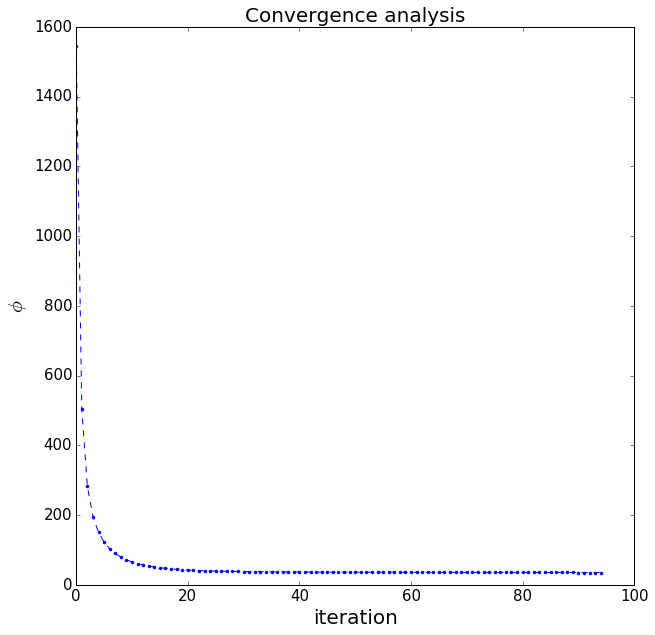

In [30]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/regular/instability/convergence_LM_NNLS_magRM_seed= %.1f' % seed
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetization direction

In [31]:
print (inc_est,dec_est)

(29.594274002495911, 18.419567496887094)


In [32]:
print (inc_R,dec_R)

(30.0, 20.0)


### Comparison between observed data and predicted data

In [33]:
pred = fc.tfa_layer(reg_grid['x'],reg_grid['y'],reg_grid['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [34]:
res = pred - data_obs

In [35]:
r_norm,r_mean,r_std = fc.residual(data_obs,pred)

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


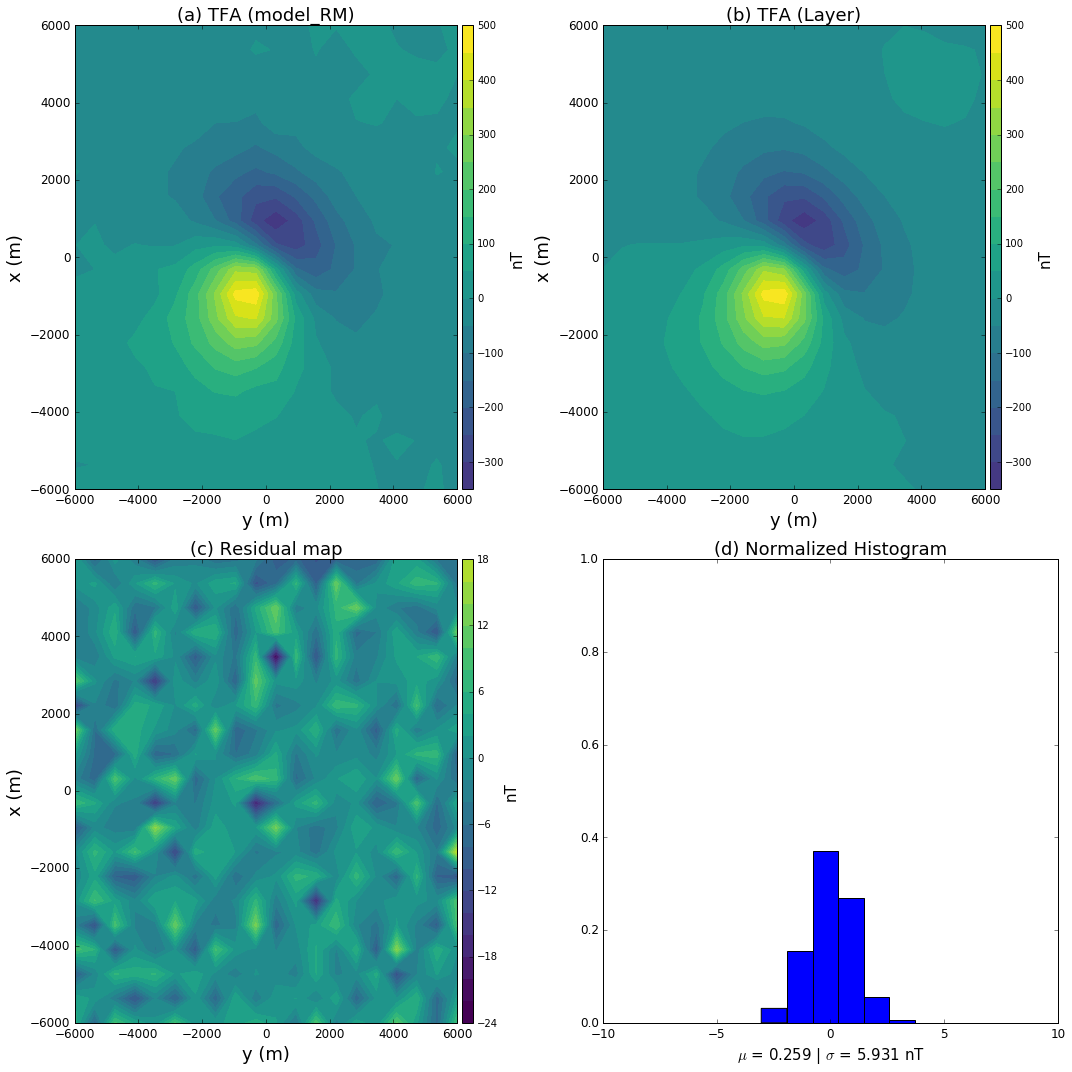

In [36]:
title_font = 18
bottom_font = 15
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(15,15), tight_layout=True)

ranges = saturation_factor*np.abs([data_obs.max(), 
                                   data_obs.min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(2,2,1)
plt.contourf(reg_grid['y'].reshape(reg_grid['shape']),
             reg_grid['x'].reshape(reg_grid['shape']), 
             data_obs.reshape(reg_grid['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_RM)',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,2)
plt.contourf(reg_grid['y'].reshape(reg_grid['shape']),
             reg_grid['x'].reshape(reg_grid['shape']),
             pred.reshape(reg_grid['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,3)
plt.contourf(reg_grid['y'].reshape(reg_grid['shape']),
             reg_grid['x'].reshape(reg_grid['shape']),
             res.reshape(reg_grid['shape']), 
             20, cmap='viridis',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/regular/instability/data_fitting_LM_NNLS_magRM_seed= %.1f' % seed
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetic moment within the layer

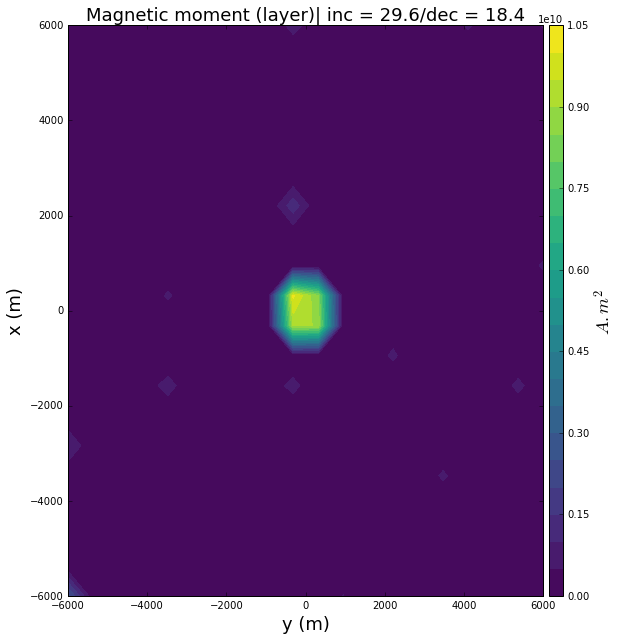

In [37]:
title_font = 18
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer), 20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)| inc = %.1f/dec = %.1f'% (inc_est,dec_est), fontsize=title_font)

file_name = 'figs/regular/instability/magnetic_moment_positive_LM_NNLS_magRM_seed= %.1f' % seed
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Results

#### Generating .pickle file

In [38]:
#now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
#data_set['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [39]:
#file_name = 'data/results_IM_reg.pickle'
#with open(file_name, 'w') as f:
#    pickle.dump(results_RM_reg, f)
#    
#saved_files.append(file_name)


### Saved files

In [40]:
#with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
#    q.write('# Saved files \n')
#    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
#    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
#    q.write('\n\n'+header+'\n\n')
#    for i, sf in enumerate(saved_files):
#        print '%d  %s' % (i+1,sf)
#        q.write('*  `%s` \n' % (sf))